In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [2]:
torch.cuda.set_device(6)

In [6]:
# dls_feat = get_3d_dls_feat(Meta.df_comb1, path_feat256, bs=64)
dls_feat = get_seutao_dls_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


In [8]:
x,y = dls_feat.one_batch()

## Model

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [10]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [12]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048
        self.conv = nn.Sequential(
            ConvLayer(512, 1024, stride=2),
            ConvLayer(1024, 1024, stride=2),
            ConvLayer(1024, d_model, stride=2),
            nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        self.hook = ReshapeBodyHook(self.conv)
        
        n_head = 4
        encoder_layers = TransformerEncoderLayer(d_model, n_head, d_model*2)
        self.transformer = TransformerEncoder(encoder_layers, 4)
        
        self.head = nn.Sequential(
            nn.Linear(d_model,6)
        )
        
    def forward(self, x):
        x = torch.cat(x, axis=-1)
        feat = self.transformer(x.transpose(0,1))
        return self.head(feat.transpose(0,1))
#         feat = self.transformer(x.transpose(0,1))
#         return self.head(feat.transpose(0,1))

In [13]:
m = SeqHead().cuda()

In [14]:
learn = get_learner(dls_feat, m)

In [15]:
learn.add_cb(DePadLoss())

## Training

In [17]:
name = 'seutao_feat_transformer_meta'

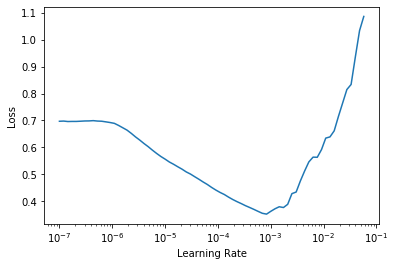

In [13]:
learn.lr_find()

In [18]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

AssertionError: 